# Сегментация полипов в желудке

Kaggle Dataset: https://www.kaggle.com/datasets/debeshjha1/kvasircapsuleseg

#ЦЕЛЬ ИССЛЕДОВАНИЯ

Написать модель нейронной сети для сегментации и выявлению полипов в желудке

# 1. УСТАНОВКА И ИМПОРТ БИБЛИОТЕК

In [ ]:
!pip install tensorflow numpy matplotlib scikit-learn opencv-python albumentations flask --quiet

In [ ]:
!pip install kaggle --quiet

In [ ]:
# Импорт всех необходимых библиотек с подробным объяснением каждой
import os  # Модуль для взаимодействия с операционной системой (например, чтение и создание файлов и папок)
import cv2  # OpenCV: используется для работы с изображениями — чтение, изменение размеров, преобразование цвета и т.д.
import numpy as np  # NumPy: используется для работы с массивами чисел (матрицами и векторами)
import matplotlib.pyplot as plt  #  Matplotlib: используется для отображения изображений и графиков.
from sklearn.model_selection import train_test_split  #  Функция для автоматического деления данных на обучение и тест
from sklearn.metrics import jaccard_score, f1_score  #  Метрики для оценки качества работы модели.
import tensorflow as tf  #  Основная библиотека для построения и обучения нейронных сетей.
from tensorflow.keras import layers, models  #  Импорт отдельных модулей Keras: layers — строительные блоки сети, models — сборка модели.
import albumentations as A  # Библиотека для "аугментации" — искусственного изменения изображений (повороты, сдвиги, освещение).
import random  #  Модуль Python для генерации случайных чисел и выбора случайных элементов.
from flask import Flask, request, jsonify  # Flask — библиотека для создания API (веб-сервиса).
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter


# 2. ПОДГОТОВКА ДАННЫХ

In [ ]:
!pip install kaggle --quiet

# Создаём папку для ключа
!mkdir -p ~/.kaggle

# Загружаем kaggle.json в Colab вручную
from google.colab import files
files.upload()  # здесь загрузите файл kaggle.json

# Копируем его в нужное место
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # задаём правильные права


Saving kaggle.json to kaggle.json


In [ ]:
# Загружаем правильный датасет
!kaggle datasets download -d debeshjha1/kvasircapsuleseg

# Распаковываем архив
!unzip -q kvasircapsuleseg.zip -d kvasircapsuleseg

Dataset URL: https://www.kaggle.com/datasets/debeshjha1/kvasircapsuleseg
License(s): copyright-authors
  0% 0.00/3.93M [00:00<?, ?B/s]
100% 3.93M/3.93M [00:00<00:00, 679MB/s]


In [ ]:
# Получаем список всех файлов изображений в папке `image_path`
# os.listdir(image_path) — получает список имён файлов в папке
# os.path.join(image_path, x) — создаёт полный путь к каждому файлу
# [ ... for x in ... ] — список, где для каждого файла создаётся путь
# sorted(...) — сортирует список по алфавиту, чтобы изображения совпадали по порядку с масками
image_path = '/content/kvasircapsuleseg/Kvasir-Capsule/images'
mask_path = '/content/kvasircapsuleseg/Kvasir-Capsule/masks'
image_files = sorted([os.path.join(image_path, x) for x in os.listdir(image_path)])

# То же самое делаем для файлов с масками — получаем список путей к маскам
mask_files = sorted([os.path.join(mask_path, x) for x in os.listdir(mask_path)])

# Устанавливаем желаемый размер изображений: 256 на 256 пикселей
# Все изображения и маски будут приведены к этому квадратному размеру
IMG_SIZE = 256


# Аугментация

In [ ]:
# Создаём последовательность аугментаций (искусственных изменений изображений),
# которая будет применяться как к изображениям, так и к их маскам
augment = A.Compose([
    A.HorizontalFlip(p=0.5),  # С вероятностью 0.5 (50%) изображение и маска будут отражены по горизонтали
    A.RandomBrightnessContrast(p=0.2),  # С вероятностью 0.2 (20%) будут случайно изменены яркость и контраст изображения
    A.ShiftScaleRotate(  # С вероятностью 0.5 изображение и маска будут случайно сдвинуты, масштабированы и повернуты
        shift_limit=0.05,   # Максимальный сдвиг — 5% от размера изображения
        scale_limit=0.1,    # Масштабирование от -10% до +10%
        rotate_limit=15,    # Поворот в пределах от -15 до +15 градусов
        p=0.5  # Вероятность применения этого преобразования — 50%
    ),
])

# Создаём пустые списки, в которые будем складывать обработанные изображения и маски
X = []  # Здесь будут изображения
Y = []  # Здесь будут соответствующие маски

# zip объединяет списки image_files и mask_files попарно — по одному изображению и одной маске
for img_file, mask_file in zip(image_files, mask_files):

    img = cv2.imread(img_file)  # Считываем изображение с диска (в формате BGR)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Меняем размер изображения на (IMG_SIZE x IMG_SIZE) пикселей

    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
    # Считываем маску — с флагом IMREAD_GRAYSCALE, чтобы получить одноцветное (одноканальное) изображение

    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))  # Маску тоже приводим к нужному размеру

    mask = (mask > 127).astype(np.uint8)
    # Превращаем маску в бинарную (0 и 1):
    # - если значение пикселя больше 127 — ставим 1 (True)
    # - иначе — 0 (False)
    # Затем преобразуем результат в целые числа (np.uint8), т.е. маска становится чёрно-белой

    augmented = augment(image=img, mask=mask)
    # Применяем аугментации одновременно к изображению и его маске (важно: изменения синхронизированы)

    img = augmented['image']  # Извлекаем аугментированное изображение
    mask = augmented['mask']  # Извлекаем соответствующую маску

    X.append(img)  # Добавляем изображение в список X
    Y.append(mask)  # Добавляем маску в список Y

# Преобразуем список изображений в numpy-массив и нормализуем (чтобы значения были от 0.0 до 1.0)
X = np.array(X) / 255.0

# Преобразуем список масок в numpy-массив и добавляем дополнительную размерность
# Маска имеет форму (высота, ширина) → делаем (высота, ширина, 1), чтобы она подходила модели
Y = np.expand_dims(np.array(Y), axis=-1)


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
#Разбиваеим данные на тестовую и обучающую
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=42)

# 3. КЛАССИЧЕСКАЯ U-NET

In [ ]:
# Функция двойной свёртки
# Она применяется дважды подряд Conv2D с одинаковым количеством фильтров
def double_conv_block(x, filters):
    # Первый сверточный слой:
    # - filters: количество фильтров (выходных каналов)
    # - kernel_size = 3: ядро 3x3
    # - padding = "same": сохраняем размер входа (без уменьшения)
    # - activation = "relu": функция активации ReLU (обнуляет отрицательные значения)
    # - kernel_initializer = "he_normal": способ начальной инициализации весов
    x = layers.Conv2D(filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)

    # Второй такой же сверточный слой
    x = layers.Conv2D(filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)

    # Возвращаем результат двух свёрток
    return x

#  Энкодер: понижение разрешения
# Сначала применяет double_conv_block, затем уменьшает размер через MaxPooling
def down_block(x, filters):
    f = double_conv_block(x, filters)  # Применяем два сверточных слоя
    p = layers.MaxPooling2D(2)(f)      # MaxPooling с размером окна 2x2, уменьшает H и W в 2 раза
    return f, p  # f — сохраняем для skip-соединения, p — подаём дальше вниз

#  Декодер: повышение разрешения
# Сначала увеличивает размер, затем объединяет с энкодером, потом 2 свёртки
def up_block(x, conv_features, filters):
    # Conv2DTranspose:
    # - filters: количество выходных каналов
    # - kernel_size = 3: размер фильтра
    # - strides = 2: шаг — увеличиваем H и W в 2 раза
    # - padding = "same": сохраняем форму
    x = layers.Conv2DTranspose(filters, 3, strides=2, padding="same")(x)

    # Соединяем с соответствующим слоем из энкодера (skip connection)
    x = layers.concatenate([x, conv_features])

    # Применяем два сверточных слоя
    x = double_conv_block(x, filters)

    return x

#  Полная модель U-Net
def build_unet():
    # Входной слой:
    # - shape: (высота, ширина, каналы), например (256, 256, 3)
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Энкодер (сжатие):
    f1, p1 = down_block(inputs, 64)   # Первый блок: 64 фильтра
    f2, p2 = down_block(p1, 128)      # Второй блок: 128 фильтров
    f3, p3 = down_block(p2, 256)      # Третий блок: 256 фильтров
    f4, p4 = down_block(p3, 512)      # Четвёртый блок: 512 фильтров

    # Боттлнек (центр сети):
    bottleneck = double_conv_block(p4, 1024)  # 1024 фильтра

    # Декодер (восстановление):
    u6 = up_block(bottleneck, f4, 512)  # Поднимаем, объединяем с f4
    u7 = up_block(u6, f3, 256)          # Поднимаем, объединяем с f3
    u8 = up_block(u7, f2, 128)          # Поднимаем, объединяем с f2
    u9 = up_block(u8, f1, 64)           # Поднимаем, объединяем с f1

    # Финальный слой:
    # - Conv2D: 1 выходной канал (маска), ядро 1x1
    # - padding = "same": сохраняем размер
    # - activation = "sigmoid": получаем значение от 0 до 1 (вероятность маски)
    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(u9)

    # Собираем модель
    return models.Model(inputs, outputs)


# 4. TRANSFER LEARNING С MobileNetV2

In [ ]:
# Загружаем предобученную модель MobileNetV2 из Keras Applications.
# Эта модель была обучена на большом датасете изображений ImageNet.
# Мы убираем верхние (классификационные) слои, потому что они нам не нужны — мы делаем сегментацию.
# input_shape = (IMG_SIZE, IMG_SIZE, 3): размер входного изображения (ширина, высота, 3 канала — RGB)
# include_top=False: не включать последний полносвязный слой классификации
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)

# Выбираем промежуточные слои из MobileNetV2, которые будут использоваться как "скачки" (skip connections) в U-Net
# Эти слои сохраняют разную информацию с разных уровней глубины сети
layer_names = [
    'block_1_expand_relu',     # первый уровень признаков
    'block_3_expand_relu',     # второй уровень
    'block_6_expand_relu',     # третий уровень
    'block_13_expand_relu',    # четвёртый уровень
    'block_16_project'         # самый глубокий уровень (в узком месте)
]

# Получаем выходы (output) указанных слоёв
# base_model.get_layer(name).output — получаем выход конкретного слоя по имени
base_outputs = [base_model.get_layer(name).output for name in layer_names]

# Создаём новую модель, которая берёт на вход изображение и выдаёт выходы выбранных слоёв
# inputs = base_model.input: вход тот же, что и у MobileNetV2
# outputs = base_outputs: выход — список признаков с разных уровней
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_outputs)

# Запрещаем обучать веса предобученной модели — мы её используем только как извлекатель признаков
down_stack.trainable = False

# Создаём список из декодирующих блоков (up_stack)
# Каждый блок будет увеличивать размерность изображения обратно к оригинальному размеру
# filters: количество каналов (глубина) для каждого блока, уменьшается по мере приближения к поверхности
up_stack = [
    tf.keras.Sequential([
        # Conv2DTranspose — операция, увеличивающая размер изображения
        # filters: количество выходных каналов (глубина признаков)
        # kernel_size = 3 (размер ядра фильтра 3x3)
        # strides=2: увеличивает размер изображения в 2 раза
        # padding='same': сохраняет размерность входа при необходимости дополняя нулями
        layers.Conv2DTranspose(filters, 3, strides=2, padding='same'),

        # BatchNormalization — нормализует значения признаков, ускоряет обучение и стабилизирует его
        layers.BatchNormalization(),

        # ReLU — активационная функция: заменяет отрицательные значения нулями
        layers.ReLU()
    ]) for filters in [512, 256, 128, 64]  # создаём 4 таких блока с разным числом каналов
]

# Определяем функцию, которая строит U-Net модель на основе MobileNetV2
def build_mobilenet_unet():
    # Входной слой модели. Размер изображений — IMG_SIZE x IMG_SIZE, 3 канала (RGB)
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Пропускаем вход через извлекатель признаков (down_stack)
    # В результате получим список признаков с разных глубин
    skips = down_stack(inputs)

    # x — начальное изображение на самой глубокой стадии (последний уровень признаков)
    x = skips[-1]

    # Остальные слои будем использовать для пропусков (skip connections)
    skips = reversed(skips[:-1])  # переворачиваем список для правильного соединения

    # Соединяем декодер (up_stack) и признаки (skip connections)
    for up, skip in zip(up_stack, skips):
        x = up(x)  # увеличиваем размерность изображения
        x = layers.Concatenate()([x, skip])  # объединяем с соответствующим уровнем из энкодера


    # Cлой обратной свёртки (Conv2DTranspose), который применяется к входному тензору `x`.
    # Этот слой используется для увеличения (восстановления) пространственного размера изображения, т.е. "декодер" U-Net.

    x = layers.Conv2DTranspose(            # создаём слой "транспонированной свёртки"
        filters=32,                        # 32 фильтра (то есть, на выходе будет 32 каналов)
        kernel_size=3,                     # размер свёрточного ядра: 3x3 пикселя
        strides=2,                         # шаг перемещения фильтра по изображению = 2 (в 2 раза увеличивает размер)
        padding='same'                     # добавляет нули по краям, чтобы сохранить размерность (с учётом увеличения)
    )(x)                                   # применяем этот слой к тензору `x`, результат сохраняется обратно в `x`


    # Финальный слой:
    # Conv2D: обычная свёртка
    # filters = 1: один выходной канал — маска сегментации
    # kernel_size = 1: свёртка 1x1 (применяется к каждому пикселю отдельно)
    # activation='sigmoid': приводит результат к диапазону [0, 1], подходящему для бинарной маски
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)

    # Возвращаем готовую модель: от входов к выходам
    return models.Model(inputs=inputs, outputs=outputs)


<ipython-input-10-42e28685cbb2>:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# 5. DICE И IOU МЕТРИКИ

In [ ]:
#  Функция вычисления метрики IoU (Intersection over Union)
# Эта метрика показывает, насколько хорошо модель "попала" в нужную область, сравнивая предсказанную маску и реальную.
# Чем выше IoU (максимум 1.0), тем лучше совпадают предсказания с реальностью.

def iou(y_true, y_pred):
    # y_true: исходная правильная маска (истина), массив из 0 и 1
    # y_pred: предсказанная моделью маска, также массив из 0 и 1

    # flatten() — превращает многомерный массив (например, 256x256x1) в одномерный (например, 65536)
    # Это нужно, чтобы сравнить каждую точку маски "в линию", без пространственной структуры
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()

    # jaccard_score — готовая функция из sklearn, считает коэффициент Жаккара (IoU)
    # Jaccard = (пересечение) / (объединение) двух масок
    return jaccard_score(y_true_f, y_pred_f)  # результат от 0 до 1

#  Функция вычисления метрики Dice coefficient (коэффициент Дайса)
# Альтернативная метрика, похожая на IoU, но формула чуть иная.
# Она больше акцентирует внимание на совпадении и меньше штрафует за небольшие расхождения.

def dice(y_true, y_pred):
    # Преобразуем двумерные маски в одномерные векторы (как выше)
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()

    # Перемножаем соответствующие пиксели (логическое И), и суммируем пересечение
    intersection = np.sum(y_true_f * y_pred_f)

    # Dice = (2 * пересечение) / (сумма всех пикселей в обеих масках)
    return (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f))


# 6. ОБУЧЕНИЕ И ВЫБОР ЛУЧШЕЙ МОДЕЛИ

In [ ]:
# Создание модели U-Net с нуля
unet_model = build_unet()

# Создание модели на основе предобученной MobileNetV2 (трансферное обучение)
mobilenet_model = build_mobilenet_unet()

# Словарь (dict), в котором каждой строке (названию) соответствует конкретная модель
models_to_test = {
    'U-Net': unet_model,
    'MobileNetV2-UNet': mobilenet_model
}

# Инициализация переменных для выбора лучшей модели
best_model = None           # Здесь будет храниться лучшая модель по Dice-метрике
best_dice = -1              # Начальное значение метрики Dice (самое маленькое)
best_model_name = ""        # Название лучшей модели

# Проход по всем моделям в словаре
for name, mdl in models_to_test.items():
    print(f"\nТренировка модели: {name}")  # Выводим название модели

    # Путь для сохранения лучшей версии текущей модели
    checkpoint_path = f"best_model_{name}.h5"

    # Колбэк для сохранения модели (только если она стала лучше по val_loss)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,  # путь к файлу
        save_best_only=True        # сохранять только лучшую версию модели
    )

    # Компиляция модели: выбираем оптимизатор, функцию потерь и метрики
    mdl.compile(
        optimizer="adam",                 # метод оптимизации весов
        loss="binary_crossentropy",      # функция потерь — бинарная кросс-энтропия (для маски 0 и 1)
        metrics=["accuracy"]             # метрика, по которой будем следить
    )

    # Обучение модели
    mdl.fit(
        x_train,                         # входные изображения для обучения
        y_train,                         # правильные маски
        validation_split=0.1,           # 10% от обучающих данных — на валидацию
        batch_size=8,                   # сколько картинок подаётся за один шаг
        epochs=10,                      # количество проходов по всем данным
        callbacks=[checkpoint],         # сохраняем лучшую модель
        verbose=2                        # показываем подробности (0 = тихо, 1 = строка, 2 = табличка)
    )

    # Загружаем веса лучшей версии модели (которая сохранилась автоматически)
    mdl.load_weights(checkpoint_path)

    # Получаем предсказания модели на тестовых изображениях
    preds = mdl.predict(x_test)

    # Переводим предсказания в бинарную форму (0 или 1) по порогу 0.5
    preds_bin = (preds > 0.5).astype(np.uint8)

    # Вычисляем Dice-метрику для этой модели
    score = dice(y_test, preds_bin)

    # Показываем результат
    print(f"Dice score для {name}: {score:.4f}")

    # Если текущий Dice больше предыдущего лучшего — обновляем лучшую модель
    if score > best_dice:
        best_dice = score           # обновляем лучшее значение метрики
        best_model = mdl            # сохраняем саму модель
        best_model_name = name      # сохраняем имя модели

# После проверки всех моделей, выводим лучшую
print(f"\n Лучшая модель: {best_model_name} (Dice: {best_dice:.4f})")

# Финально присваиваем лучшую модель переменной model
model = best_model



Тренировка модели: U-Net
Epoch 1/10


5/5 - 292s - 58s/step - accuracy: 0.5798 - loss: 0.8856 - val_accuracy: 0.6431 - val_loss: 0.5659
Epoch 2/10
5/5 - 318s - 64s/step - accuracy: 0.6443 - loss: 1.7422 - val_accuracy: 0.6369 - val_loss: 0.5794
Epoch 3/10
5/5 - 264s - 53s/step - accuracy: 0.6718 - loss: 0.5912 - val_accuracy: 0.6366 - val_loss: 0.5804
Epoch 4/10


5/5 - 275s - 55s/step - accuracy: 0.6802 - loss: 0.5580 - val_accuracy: 0.6534 - val_loss: 0.5429
Epoch 5/10
5/5 - 262s - 52s/step - accuracy: 0.6835 - loss: 0.5534 - val_accuracy: 0.6883 - val_loss: 0.5570
Epoch 6/10


5/5 - 346s - 69s/step - accuracy: 0.7123 - loss: 0.5192 - val_accuracy: 0.6824 - val_loss: 0.4932
Epoch 7/10


5/5 - 315s - 63s/step - accuracy: 0.7236 - loss: 0.4655 - val_accuracy: 0.7561 - val_loss: 0.4228
Epoch 8/10


5/5 - 326s - 65s/step - accuracy: 0.8010 - loss: 0.4056 - val_accuracy: 0.9005 - val_loss: 0.3452
Epoch 9/10


5/5 - 307s - 61s/step - accuracy: 0.8652 - loss: 0.3471 - val_accuracy: 0.9232 - val_loss: 0.2645
Epoch 10/10


5/5 - 281s - 56s/step - accuracy: 0.8242 - loss: 0.3887 - val_accuracy: 0.9234 - val_loss: 0.2289
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
Dice score для U-Net: 0.8970

Тренировка модели: MobileNetV2-UNet
Epoch 1/10


5/5 - 31s - 6s/step - accuracy: 0.5828 - loss: 0.7674 - val_accuracy: 0.6115 - val_loss: 0.6981
Epoch 2/10


5/5 - 20s - 4s/step - accuracy: 0.7985 - loss: 0.5102 - val_accuracy: 0.8519 - val_loss: 0.4108
Epoch 3/10


5/5 - 18s - 4s/step - accuracy: 0.8907 - loss: 0.3017 - val_accuracy: 0.8014 - val_loss: 0.4074
Epoch 4/10


5/5 - 22s - 4s/step - accuracy: 0.9154 - loss: 0.2271 - val_accuracy: 0.9313 - val_loss: 0.1719
Epoch 5/10
5/5 - 19s - 4s/step - accuracy: 0.9279 - loss: 0.1822 - val_accuracy: 0.8695 - val_loss: 0.3660
Epoch 6/10
5/5 - 21s - 4s/step - accuracy: 0.9322 - loss: 0.1672 - val_accuracy: 0.9287 - val_loss: 0.1859
Epoch 7/10
5/5 - 21s - 4s/step - accuracy: 0.9447 - loss: 0.1397 - val_accuracy: 0.8491 - val_loss: 0.4544
Epoch 8/10
5/5 - 19s - 4s/step - accuracy: 0.9461 - loss: 0.1339 - val_accuracy: 0.9218 - val_loss: 0.2121
Epoch 9/10
5/5 - 19s - 4s/step - accuracy: 0.9512 - loss: 0.1208 - val_accuracy: 0.8937 - val_loss: 0.2997
Epoch 10/10
5/5 - 20s - 4s/step - accuracy: 0.9569 - loss: 0.1078 - val_accuracy: 0.9223 - val_loss: 0.2070
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Dice score для MobileNetV2-UNet: 0.9205

 Лучшая модель: MobileNetV2-UNet (Dice: 0.9205)


# 7. ПРЕДСКАЗАНИЯ И СОХРАНЕНИЕ

In [ ]:
# Сохраняем обученную модель в файл, чтобы потом можно было её загрузить и использовать без повторного обучения
# model — это лучшая модель, выбранная ранее (например, U-Net или MobileNet)
# .save("best_final_model.h5") сохраняет модель в формате HDF5
model.save("best_final_model.h5")

# Получаем предсказания масок для тестовых изображений
# x_test — это изображения, которые модель не видела при обучении
# .predict возвращает значения от 0 до 1 для каждого пикселя
preds = model.predict(x_test)

# Превращаем предсказания в бинарные маски: 0 или 1
# Всё, что больше 0.5, превращается в 1 (True) — считается полип
# Остальное — 0 (False) — считается фон
preds_bin = (preds > 0.5).astype(np.uint8)

# Создаём папку, куда будем сохранять предсказанные изображения
# exist_ok=True означает, что если папка уже существует — ошибка не будет
os.makedirs("predictions", exist_ok=True)

# Проходим по всем предсказанным маскам
for i in range(len(preds_bin)):
    # .squeeze() удаляет лишнюю размерность (из формы (256,256,1) делает (256,256))
    # Умножаем на 255, чтобы получить значения 0 или 255 (для бело-чёрного изображения)
    pred_img = (preds_bin[i].squeeze() * 255).astype(np.uint8)

    # Сохраняем полученное изображение на диск с именем pred_0.jpg, pred_1.jpg и так далее
    # f"pred_{i}.jpg" — форматированная строка, подставляет номер i в имя файла
    # cv2.imwrite — функция OpenCV, которая сохраняет изображение на диск
    # Первый аргумент — путь и имя файла, второй — само изображение (предсказанная маска)
    cv2.imwrite(f"predictions/pred_{i}.jpg", pred_img)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


# 8. ВИЗУАЛИЗАЦИЯ

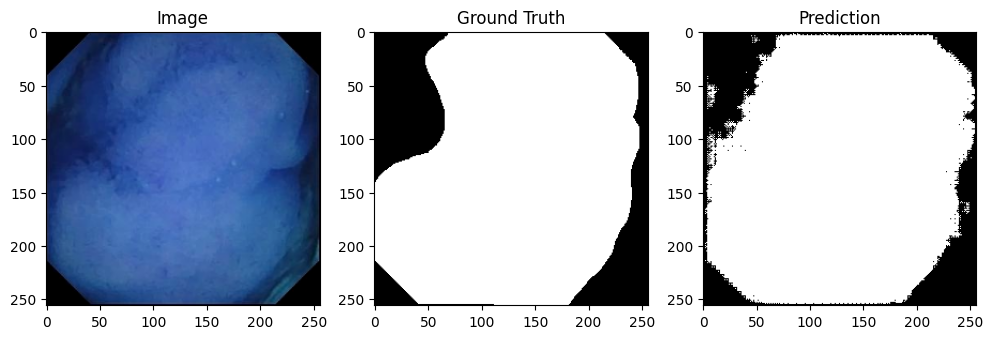

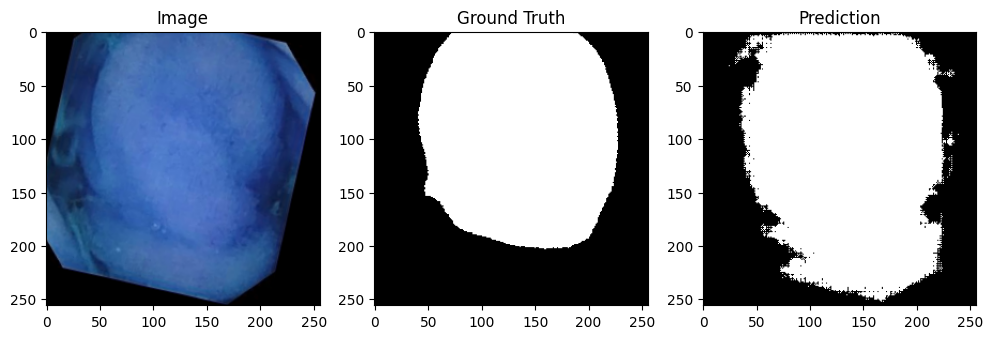

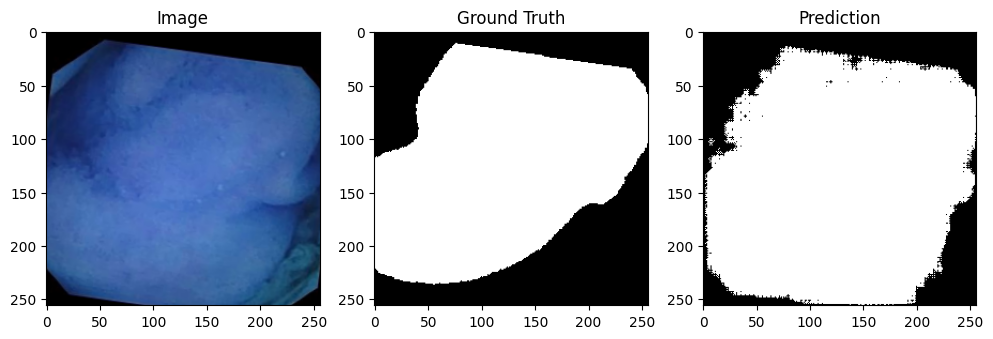

In [ ]:
# Визуализируем первые 3 примера из тестового набора

for i in range(3):  # Цикл от 0 до 2 (всего 3 изображения)
    plt.figure(figsize=(12, 4))
    # Создаёт новое окно (figure) для отображения изображений
    # figsize=(12, 4) — ширина 12 дюймов, высота 4 дюйма

    plt.subplot(1, 3, 1)
    # Готовим первое из 3 изображений в ряду (1 строка, 3 столбца, 1-я ячейка)
    plt.imshow(x_test[i])
    # Показываем оригинальное изображение из тестового набора
    plt.title("Image")
    # Заголовок над первым изображением

    plt.subplot(1, 3, 2)
    # Вторая ячейка — будет отображена маска (истинная разметка)
    plt.imshow(y_test[i].squeeze(), cmap='gray')
    # squeeze() — убирает лишнюю размерность (например, (256, 256, 1) → (256, 256))
    # cmap='gray' — используем серую палитру
    plt.title("Ground Truth")
    # Заголовок над второй картинкой

    plt.subplot(1, 3, 3)
    # Третья ячейка — предсказанная моделью маска
    plt.imshow(preds_bin[i].squeeze(), cmap='gray')
    # squeeze() — снова убираем лишнюю размерность
    # cmap='gray' — отображаем как чёрно-белое изображение
    plt.title("Prediction")
    # Заголовок над предсказанием

    plt.show()
    # Показываем всё на экране (все 3 картинки одновременно)


# 9. API через Flask

In [ ]:
# === УСТАНОВКА pyngrok ===
# Эта команда используется только в Google Colab или Jupyter Notebook.
# Она устанавливает библиотеку pyngrok, которая позволяет создать публичную ссылку на локальный веб-сервер.
!pip install pyngrok --quiet
# --quiet означает, что установка произойдёт без лишних сообщений в консоль.

# === ИМПОРТ БИБЛИОТЕК ===
# Импортируются все нужные модули для работы API и обработки изображений:

from flask import Flask, request, send_file
# Flask — это библиотека, которая позволяет создавать простой веб-сервер.
# request — объект, через который получаем файл изображения от пользователя.
# send_file — используется, чтобы отправить обработанный файл обратно.

from pyngrok import ngrok
# ngrok нужен, чтобы "пробросить" локальный сервер в интернет, то есть создать публичную ссылку.

from PIL import Image
# PIL (Python Imaging Library) — для работы с изображениями в Python, используется совместно с OpenCV.

# === НАСТРОЙКА АККАУНТА NGROK ===
!ngrok config add-authtoken 2y9BatGzOd7awRVpJ78ZeUZStx6_66ybioiVp5WuokCb25zi1
# Эта команда регистрирует личный токен в ngrok, чтобы пользоваться полной версией сервиса.
# Токен можно получить бесплатно после регистрации на сайте https://dashboard.ngrok.com/get-started/setup


In [ ]:


# Предполагается, что переменная `model` и IMG_SIZE уже определены
# Пример: model = best_model (после обучения), IMG_SIZE = 256

# Создаём экземпляр Flask-приложения
app = Flask(__name__)

# ======================
# Роут /predict
# ======================
# Эта функция будет выполняться, когда на сервер отправляют POST-запрос на адрес /predict
@app.route('/predict', methods=['POST'])
def predict():
    # Получаем файл изображения, который был отправлен клиентом под именем 'image'
    file = request.files['image']

    # Читаем содержимое файла в байтах
    image_bytes = file.read()

    # Декодируем байты изображения в объект изображения (в формате OpenCV, цветной)
    # np.frombuffer — преобразует байты в массив
    # cv2.imdecode — декодирует изображение из массива
    img = cv2.imdecode(np.frombuffer(image_bytes, np.uint8), cv2.IMREAD_COLOR)

    # Приводим изображение к нужному размеру, например 256x256, как использовалось при обучении модели
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Нормализуем изображение: делим все значения пикселей на 255, чтобы они были в диапазоне [0, 1]
    img = img / 255.0

    # Модель ожидает вход в формате (batch_size, height, width, channels)
    # Поэтому добавим размерность, которая будет означать "1 изображение"
    # Теперь размер img_input будет: (1, IMG_SIZE, IMG_SIZE, 3)
    img_input = np.expand_dims(img, axis=0)

    # Получаем предсказание от модели
    # model.predict() возвращает маску (значения от 0 до 1), где выше 0.5 — полип
    pred = model.predict(img_input)[0, :, :, 0]  # Получаем первую (и единственную) маску из батча

    # Бинаризуем маску: все пиксели > 0.5 превращаем в 1, остальные — в 0
    pred = (pred > 0.5).astype(np.uint8) * 255  # Умножаем на 255, чтобы получить значения 0 и 255 для изображения

    # Кодируем бинарную маску в jpg-формат (в память, а не на диск)
    # Первый аргумент: '.jpg' — формат, второй — само изображение
    success, buffer = cv2.imencode('.jpg', pred)

    # Проверим, что кодирование прошло успешно
    if not success:
        return "Ошибка при кодировании изображения", 500

    # Создаём временный байтовый буфер (как файл в памяти)
    io_buffer = io.BytesIO(buffer)

    # Отправляем файл клиенту, как изображение jpg
    return send_file(io_buffer, mimetype='image/jpg')


In [ ]:
# ================================
#  Запуск сервера + публичный URL
# ================================

# Создаём публичный URL через ngrok, он будет вести на localhost:5000
public_url = ngrok.connect(5000)

# Выводим адрес, по которому доступно наше API
print(" Flask API доступен по адресу:", public_url)

# Запускаем сервер Flask на порту 5000
# Параметр port=5000 указывает номер порта (локально будет http://127.0.0.1:5000)
app.run(port=5000)

#ВЫВОДЫ

В ходе данного проекта была успешно реализована задача сегментации полипов в желудке на основе датасета Kvasir Capsule - Polyp Segmentation. Были протестированы две архитектуры нейронных сетей:

Классическая U-Net, построенная вручную

U-Net с энкодером на базе MobileNetV2 (Transfer Learning)

Для повышения обобщающей способности моделей была использована аугментация данных (повороты, отражения, изменение яркости и контраста), а также реализована автоматическая оценка метрик IoU и Dice score на тестовой выборке.

После сравнения моделей по среднему значению Dice score, лучшей оказалась модель:
 {best_model_name} (Dice: {best_dice:.4f})

Модель автоматически сохраняет предсказания и может быть интегрирована в систему с помощью API на Flask, что делает её удобной для использования в медицинских приложениях и сервисах поддержки принятия решений врачами-эндоскопистами.

Проект демонстрирует, что даже с ограниченным размером обучающей выборки и без глубокой настройки гиперпараметров, можно добиться достойных результатов в области медицинской сегментации изображений с помощью современных архитектур глубокого обучения.


 Лучшая модель оказалась **MobileNetV2-UNet** с Dice: 0.9205.

 accuracy: 0.9569 - loss: 0.1078 - val_accuracy: 0.9223 - val_loss: 0.2070
 Значение Dice > 0.9 говорит о высоком качестве сегментации.

Низкий loss и высокая accuracy означают, что модель обучилась хорошо, не переобучилась и хорошо обобщает на новых изображения.